In [55]:
from visualize_attention import *
from PIL import Image
def to_pil(x):
    return Image.fromarray( (x.permute(1,2,0).cpu().numpy()*255 ).astype("uint8") )

In [69]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
arch = 'vit_base'
patch_size = 8
model = vits.__dict__[arch](patch_size=patch_size, num_classes=0)
model.eval()
model.to(device)
#pretrained_weights = 'results/official_vitb8/dino_vitbase8_pretrain.pth'
#pretrained_weights = 'results/imagenet21k_19feb2022/checkpoint.pth'
#pretrained_weights = 'results/laion_13apr2022/checkpoint.pth'
pretrained_weights = 'results/laion_02jun2022/checkpoint.pth'
utils.load_pretrained_weights(model, pretrained_weights, 'teacher', arch, patch_size)
#state_dict = torch.load(pretrained_weights, map_location="cpu")['
#model.load_state_dict(state_dict, strict=True)

Take key teacher in provided checkpoint dict
Pretrained weights found at results/laion_02jun2022/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [62]:
if not os.path.exists("dino.jpg"):
    !wget "https://mtv.mtvnimages.com/uri/mgid:ao:image:mtv.com:42451?height=729&width=1296&format=jpg&quality=.7" --output-document=dino.jpg

In [75]:

img = Image.open("n02099601_8429.jpg")
img = img.convert('RGB')
image_size = 224
transform = pth_transforms.Compose([
    pth_transforms.Resize(image_size),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

attentions = model.get_last_selfattention(img.to(device))
nh = attentions.shape[1] # number of head
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

torch.Size([12, 1036])


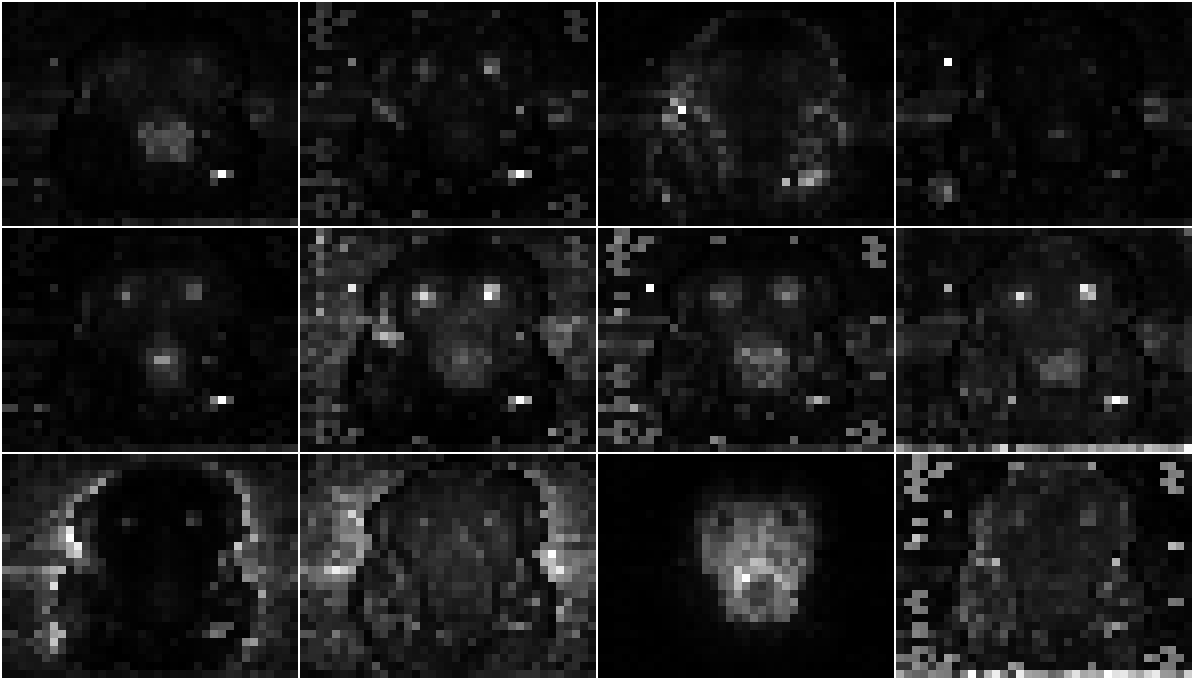

In [76]:
at = attentions.reshape(nh, w_featmap, h_featmap)
at = nn.functional.interpolate(at.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].data.cpu()
at_img = at.reshape((at.shape[0], 1, at.shape[1], at.shape[2]))
grid = torchvision.utils.make_grid(at_img, normalize=True, scale_each=True, nrow=4, pad_value=1)
to_pil(grid)

tensor(0.) tensor(1.)


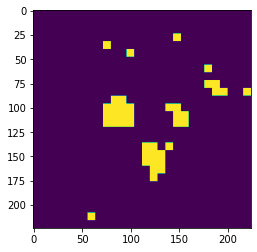

In [39]:
threshold = 0.3
# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].data.cpu()
idx = 4
print(th_attn.min(), th_attn.max())
plt.imshow(th_attn[idx])

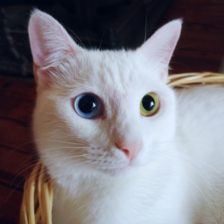

In [9]:
im = torchvision.utils.make_grid(img, normalize=True, scale_each=True)
to_pil(im)